In [1]:
import jax.numpy as jnp
import jax
import src.models
from experiments.plotting import plot_score_variable_y, plot_score_error_variable_y

import orbax.checkpoint
from src.training import utils
import flax.linen as nn



In [2]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()


sde = {"x0": (1.,), "N": 100, "dim": 1, "T": 1., "y": (5.,)}
network = {
    "output_dim": sde["dim"],
    "time_embedding_dim": 16,
    "init_embedding_dim": 16,
    "activation": nn.leaky_relu,
    "encoder_layer_dims": [16],
    "decoder_layer_dims": [128, 128],
}

training = {
    "batch_size": 1000,
    "epochs_per_load": 1,
    "lr": 0.01,
    "num_reloads": 1000,
    "load_size": 1000,
}


num_samples = training["batch_size"] * sde["N"]
x_shape = jnp.empty(shape=(num_samples, sde["dim"]))
t_shape = jnp.empty(shape=(num_samples, 1))
model = src.models.ScoreMLPDistributedEndpt(**network)
empty_train_state = utils.create_train_state(model, jax.random.PRNGKey(0), training["lr"], x_shape, x_shape, t_shape)
target = {"state":empty_train_state, "sde":sde, "network":network, "training":training}

restored = orbax_checkpointer.restore('/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/varied_y_-1.0_to_1.0', item=target)
train_state = restored["state"]
trained_score = utils.trained_score_variable_y(train_state)


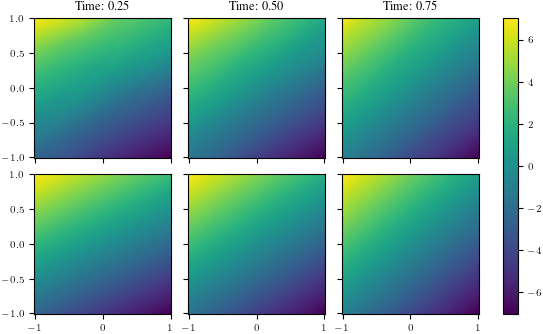

In [3]:
from src.data_generate_sde import sde_ornstein_uhlenbeck

from tueplots import bundles
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)

true_score = sde_ornstein_uhlenbeck.score
fig, axs = plot_score_variable_y(true_score, trained_score, -1, 1, -1, 1)
plt.savefig('ou_score_varied_y_-1.0_to_1.0.pdf')
plt.show()

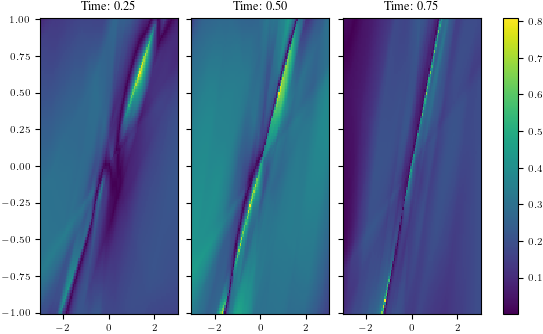

In [6]:
plot_score_error_variable_y(true_score, trained_score, -3, 3, -1, 1)

In [ ]:
import jax.numpy as jnp
import jax
import src.models
from experiments.plotting import plot_score, plot_score_error

import orbax.checkpoint
from src.training import utils
import flax.linen as nn

In [ ]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

sde = {"x0": (1.,), "N": 100, "dim": 1, "T": 1.0, "y": (1.,)}
y = sde["y"]
dim = sde["dim"]
T = sde["T"]
checkpoint_path = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/fixed_y_{y}_d_{dim}_T_{T}"

network = {
    "output_dim": sde["dim"],
    "time_embedding_dim": 16,
    "init_embedding_dim": 16,
    "activation": nn.leaky_relu,
    "encoder_layer_dims": [16],
    "decoder_layer_dims": [128, 128],
}

training = {
    "batch_size": 1000,
    "epochs_per_load": 1,
    "lr": 0.01,
    "num_reloads": 1000,
    "load_size": 1000,
}

num_samples = training["batch_size"] * sde["N"]
x_shape = jnp.empty(shape=(num_samples, sde["dim"]))
t_shape = jnp.empty(shape=(num_samples, 1))
model = src.models.ScoreMLP(**network)
model_shape = (x_shape, t_shape)
empty_train_state = utils.create_train_state(
    model, jax.random.PRNGKey(0), training["lr"], *model_shape
)

target = {"state":empty_train_state, "sde": sde, "network":network, "training":training}

restored = orbax_checkpointer.restore(checkpoint_path, item=target)
train_state = restored["state"]
trained_score = utils.trained_score(train_state)

In [ ]:
from src.data_generate_sde import sde_ornstein_uhlenbeck

from tueplots import bundles
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)

true_score = sde_ornstein_uhlenbeck.score
fig, axs = plot_score_error(true_score, trained_score, T=T, y=y)
plt.savefig(f'ou_fixed_y_error_{y}_d_{dim}_T_{T}.pdf')
plt.show()

In [7]:
import jax.numpy as jnp
import jax
import src.models

import orbax.checkpoint
from src.training import utils
import flax.linen as nn

In [29]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

sde = {"x0": 2*jnp.ones(shape=(1,)), "N": 100, "dim": 1, "T": 1.0, "y": (2.,)}
y = sde["y"]
dim = sde["dim"]
T = sde["T"]
checkpoint_path = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/normally_distributed_mean_(1.0,)_sigma_0.1"

network = {
    "output_dim": sde["dim"],
    "time_embedding_dim": 16,
    "init_embedding_dim": 16,
    "activation": nn.leaky_relu,
    "encoder_layer_dims": [16],
    "decoder_layer_dims": [128, 128],
}

training = {
    "batch_size": 1000,
    "epochs_per_load": 1,
    "lr": 0.01,
    "num_reloads": 1000,
    "load_size": 1000,
}

num_samples = training["batch_size"] * sde["N"]
x_shape = jnp.empty(shape=(num_samples, sde["dim"]))
t_shape = jnp.empty(shape=(num_samples, 1))
model = src.models.ScoreMLP(**network)
model_shape = (x_shape, t_shape)
empty_train_state = utils.create_train_state(
    model, jax.random.PRNGKey(0), training["lr"], *model_shape
)

target = {"state":empty_train_state, "sde": sde, "network":network, "training":training}

restored = orbax_checkpointer.restore(checkpoint_path, item=target)
train_state = restored["state"]
trained_score = utils.trained_score(train_state)

In [30]:
from src.data_generate_sde import utils as sde_utils
from src.data_generate_sde import time
from src.data_generate_sde import sde_ornstein_uhlenbeck

def plot_conditioned_trajectory(ts, x0, score_fn, drift, diffusion):  
    traj_keys = jax.random.split(jax.random.PRNGKey(1), 20)
    conditioned_traj = jax.vmap(
        sde_utils.conditioned, in_axes=(0, None, None, None, None, None)
    )

    trajs = conditioned_traj(
        traj_keys,
        ts,
        x0,
        score_fn,
        drift,
        diffusion,
    ).ys

    for traj in trajs:
        plt.plot(ts, traj)
    plt.show()

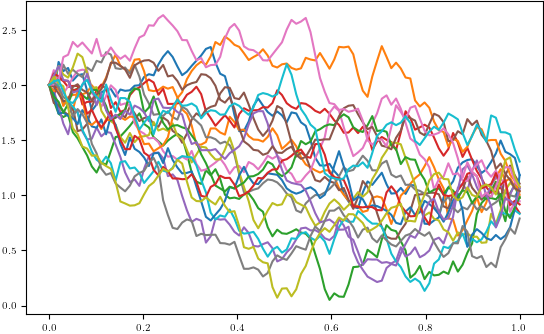

In [31]:
ts = time.grid(0, 1., 100)
drift, diffusion = sde_ornstein_uhlenbeck.vector_fields()
plot_conditioned_trajectory(ts, sde["x0"], trained_score, drift, diffusion)
